This project applies K-means clustering to create clusters of energy consumption for 216 households in Texas. The data was gathered from the Pecan Street Database (https://dataport.pecanstreet.org/) for the months of August and September of 2015. The dataset has a total of 646981 rows. Clustering load profiles allows to segment consumers on their energy behaviour pattern. This is one of the main applications of Machine Learning on the Smart Grid. 

## Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sqlite3
%matplotlib inline

## Perform query on SQLite database

In [3]:
conn = sqlite3.connect("/home/luciano/python/load_profiling/dataport")
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

## Load result into a pandas Dataframe 

In [4]:
df = pd.DataFrame(data, columns=['id','date','energy_use'])
df.head() 
# id is the id of the house in the study and energy_use in the amount of energy consumed during a 15 minute interval

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


In [32]:
df.shape

(646981, 3)

## Data wrangling

### Count the amount of missing  values

In [5]:
def count_empty_strings(data):
    """returns the percentage of empty strings in a dataframe column"""
    empty = 0
    not_empty=0
    
    for row in data:
        if row == "":
            empty += 1
        else:
            not_empty += 1
            
    return (print("there are",str(round(empty/not_empty*100))+"%","of missing values"))

In [6]:
count_empty_strings(df.energy_use)

there are 2% of missing values


### Filter out empty strings 

In [7]:
df2 = df[df['energy_use']!=""]
count_empty_strings(df2.energy_use) # how many empty values do we have now?

there are 0% of missing values


### Trasform data types

In [8]:
df2 = df2.copy()
df2.loc[:,'energy_use'] = df2.energy_use.astype(float) # transfrom load consumption values into into float

df2.loc[:,'date'] = pd.to_datetime(df2.date) # transforms date column into datetime
df2.dtypes

id                    object
date          datetime64[ns]
energy_use           float64
dtype: object

### Create columns with information about the date of data retrieval

This will be usefull later

In [9]:
# create a column that contains info if the observation is on a weekday or a weekend
df2['type_day'] = df2.date.apply(lambda x: x.isoweekday()) 

# create a column of the day of the month for a particular observation
df2['day_of_month'] = df2.date.apply(lambda x: x.day) 

# create a column of the month of the year for a particular observation
df2['month'] = df2.date.apply(lambda x: x.month) 

# sort values 
df2.sort_values(['id', 'date'], ascending=[True, True],inplace=True)

df2.reset_index(inplace=True)

### Filter out the weekends

In [10]:
df3 = df2[(df2['type_day'] != 6) & (df2['type_day'] != 7)] # select only weekdays

df3 = df3.copy()
# transfrom id column to integer
df3.loc[:,'id'] = df3['id'].astype(int) 

###  How many different housholds in the dataset?

In [11]:
households = np.unique(df3['id'])   
print("there are",np.count_nonzero(households),"different households") 

there are 216 different households


###  Create function to extract daily loads from the time-series

In [12]:
def extract_daily_load():
    """parses the time-series to extract load measurements 
     from one particular day for one particular house"""

    load_data = []
    
    for house in households:
        data_one_house = df3[df3['id'] == house]

        for month in range(7,8):
            for day in range(1,31):

                one_day_load = (data_one_house[data_one_house['month'] == month]
                                [data_one_house['day_of_month'] == day])
                if len(one_day_load) == 96: # only grab daily loads with 96 observations
                    load_data.append(one_day_load.energy_use)

    return load_data

In [13]:
load_data = extract_daily_load()

### Transform list of lists into numpy array 

In [14]:
load_data_np = np.array(load_data) # transform list of lists into numpy array

print("There are",load_data_np.shape[0],"day-loads in the dataset. Each containing",
      load_data_np.shape[1] ,"load measurements.")

There are 4702 day-loads in the dataset. Each containing 96 load measurements.


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data.
The data wil be scaled into values between 0 and 1. 

In [15]:
from sklearn.preprocessing import normalize
load_data_scaled = normalize(load_data)
load_data_scaled                                                

array([[ 0.07919184,  0.04391111,  0.07921199, ...,  0.05013277,
         0.03978909,  0.04345086],
       [ 0.03932796,  0.10140809,  0.14347421, ...,  0.05112183,
         0.0595932 ,  0.05774141],
       [ 0.05915546,  0.15391654,  0.22118042, ...,  0.06843618,
         0.07248123,  0.12173624],
       ..., 
       [ 0.13219142,  0.0292397 ,  0.01633352, ...,  0.09091795,
         0.00676467,  0.00673697],
       [ 0.01262715,  0.00986974,  0.00595242, ...,  0.00329519,
         0.10633697,  0.10918402],
       [ 0.0729647 ,  0.00425861,  0.00668233, ...,  0.13614554,
         0.06539231,  0.01496677]])

## Perform cluster analysis with K-Means Clustering

In [16]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=6)
prediction = model.fit_predict(load_data_scaled)
prediction

array([3, 2, 4, ..., 1, 4, 1], dtype=int32)

### Create function to count how many daily-loads are in each cluster 

In [27]:
def count_load_in_cluster():

    count_list = {}
    clusters = ["0","1","2","3","4","5"]
    for cluster in clusters:
        count = 0
        for cluster_prediction in prediction:
            if cluster_prediction == int(cluster):
                count += 1 

        count_list[cluster] = count
        
    return count_list

clusters = count_load_in_cluster()
clusters

{'0': 495, '1': 471, '2': 1076, '3': 1464, '4': 555, '5': 641}

## Plot the clusters

In [18]:
import datetime
from matplotlib.dates import date2num
base = datetime.date(2011, 5, 1)
x = np.arange(0,24,0.25)
date_list = [base - datetime.timedelta(minutes=y) for y in x.tolist()]
dates = []
for date in date_list:
    dates.append(date)

dates = date2num(dates)

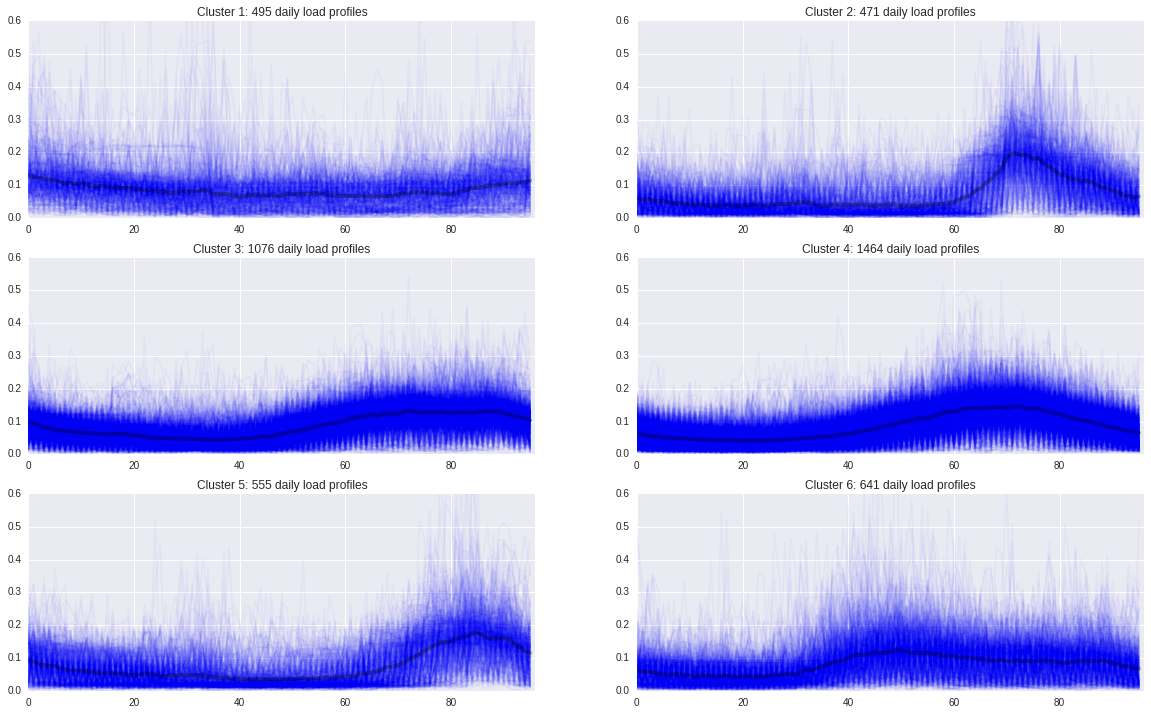

In [33]:
pylab.rcParams['figure.figsize'] = 20, 12  # that's default image size for this interactive session

fig = plt.figure()

for i in range(0,6):
    
    all_data=[]

    for x,y in zip(load_data_scaled,prediction):
            if y == i:
                all_data.append(x)
                plt.subplot(3,2,i+1)
                plt.plot(x,alpha=0.03,color="blue")
                plt.ylim(0,0.6)
                plt.xlim(0,96)
                plt.title('Cluster {}'.format(str(i+1)+': {} daily load profiles'.format(str(clusters[str(i)]))))

    all_data_array = np.array(all_data)
    mean = all_data_array.mean(axis=0)
    plt.plot(mean, alpha=0.3, color="black",linewidth=4)

plt.show()